The goal is to build a CNN model to review variants (SNVs and small INDELs) called by somatic pipeline implemented at BCGSC.

Currently, let's focus on only SNVs since it is probably the easiest task and them move on to INDELs if it works.

This work is inspired by and references deepvariant.

In [1]:
import pysam
import pandas as pd
import seaborn as sns
from matplotlib import style, colors
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### some relevant samtools commands

this command give you the reference sequence

samtools faidx /projects/rcorbettprj2/GATK4VariantCall/GRCh37-lite.fa 1:10000-10020

In [12]:
# extract reads in a region and sort based on alignment position
# samtools view -h -q 10 /projects/analysis/analysis22/A37234/merge_bwa-mem-0.7.6a/125nt/hg19a/A37234_4_lanes_dupsFlagged.bam 5:1295228-1295229 | awk 'BEGIN{OFS="\t"}{if($1 ~ /^"@"/) {print} else {if($4 >= 1295220 || $4 <=1295230) {print} else {}}}'|sort -k4n|samtools view -Sbo /projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/test.bam -

### paysam 0 indexed, bam in 1 indexed

In [2]:
# ref = '/home/pubseq/genomes/Homo_sapiens/hg19a/bwa_ind/genome/GRCh37-lite.fa' # depreciated
ref = '/projects/alignment_references/Homo_sapiens/hg19a/genome/fasta/hg19a.fa'
bam = '/projects/analysis/analysis22/A37234/merge_bwa-mem-0.7.6a/125nt/hg19a/A37234_4_lanes_dupsFlagged.bam'
# test bam only have 60 reads
bam = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/test.bam'

In [3]:
def get_ref_seqs(ref_file, region):
    """
    find sequence of reference genome in a region.
    
    Parameters
    ----------
    ref_file : str
        Path to genome FASTA file (idx file required).
    region: str
        format 'chr:start-end', example '1:10000-10003'.

    Returns
    -------
    sequence: str
        the bases of the reference genome, start to end inclusive.
    """
    return ''.join(pysam.faidx(ref, region).split('\n')[1:])

In [4]:
# confirmed ref sequence in UCSC genome browser
assert get_ref_seqs(ref, '1:10000-10003') == 'NTAA'
assert get_ref_seqs(ref, '3:178928000-178928020') == 'TATAAACTTGTTTGATTACAC'
get_ref_seqs(ref, '3:1295226-1295227')

'AT'

In [88]:
def extract_reads(bam, chrm, start, flank_length):
    """
    extract bases from reads aligned to the variant position.
    
    Parameters
    ----------
    bam: str
        Path to bam file.
    chrm, start, end: int
        start is the genome coordinate of the variant.

    Returns
    -------
    df: pandas dataframe
        rows are read name, cols are genome coordinates, 231 bases in total: 115 + snv + 115.
    """ 
    samfile = pysam.AlignmentFile(bam, 'rb')
    df = pd.DataFrame()
    read_names = []
    for pileupcolumn in samfile.pileup(str(chrm), start-10, start+10, truncate=False):# min_base_quality=0
    #     print(f'process position: {pileupcolumn.pos}, coverage is {pileupcolumn.n}')
        for pileupread in pileupcolumn.pileups:
            if not pileupread.is_del and not pileupread.is_refskip:
                read_name = pileupread.alignment.query_name
                align_pos = pileupcolumn.pos
                
                base = pileupread.alignment.query_sequence[pileupread.query_position]
#                 print(f'pileup position is {align_pos}, base is {base}')
#                 if read_name == 'HISEQ1:9:H8962ADXX:2:1202:19053:83229':
#                     print(f'read: {read_name}, {align_pos}, {base}')
                read_names.append(read_name)
                df.loc[read_name, align_pos] = base
    samfile.close()
    df = df.loc[:, pos-flank_length:pos+flank_length]
    return df

In [92]:
bam = '/projects/da_workspace/szspace/data/giab/RMNISTHS_30xdownsample.bam'
read_length = 3
pos = 239339
flank_length = read_length -1
df1 = extract_reads(bam, 1, pos, flank_length)
df1.shape

(31, 5)

In [94]:
df1.head()

,239337,239338,239339,239340,239341
HWI-D00360:7:H88WKADXX:1:1204:5390:94667,NaN,NaN,NaN,NaN,NaN
HWI-D00360:6:H81VLADXX:1:1105:3258:20512,A,NaN,NaN,NaN,NaN
HWI-D00360:6:H81VLADXX:2:1203:16741:59715,A,NaN,NaN,NaN,NaN
HWI-D00360:6:H81VLADXX:2:2216:21212:90399,A,G,G,G,G
HWI-D00360:7:H88WKADXX:2:2210:16490:29959,A,G,G,G,G


In [97]:
pileup_to_image(df1, 1, pos, flank_length)

ValueError: Shape of passed values is (4, 1), indices imply (5, 1)

In [28]:
def extract_reads_other(bam, chrm, start, end, flank_length):
    # new edit, this is not what i want, i need read overlapping with the variant position
    """
    extract bases from reads aligned to the variant position.
    
    Parameters
    ----------
    bam: str
        Path to bam file.
    chrm, start, end: int
        start is the genome coordinate of the variant.

    Returns
    -------
    df: pandas dataframe
        rows are read name, cols are genome coordinates, 231 bases in total: 115 + snv + 115.
    """ 
    samfile = pysam.AlignmentFile(bam, 'rb')
    df = pd.DataFrame()
    read_names = []
    for pileupcolumn in samfile.pileup(str(chrm), start-flank_length, start+1+flank_length, truncate=True):# min_base_quality=0
    #     print(f'process position: {pileupcolumn.pos}, coverage is {pileupcolumn.n}')
        for pileupread in pileupcolumn.pileups:
            if not pileupread.is_del and not pileupread.is_refskip:
                read_name = pileupread.alignment.query_name
                align_pos = pileupcolumn.pos
                base = pileupread.alignment.query_sequence[pileupread.query_position]
#                 if read_name == 'HISEQ1:9:H8962ADXX:2:1202:19053:83229':
#                     print(f'read: {read_name}, {align_pos}, {base}')
                read_names.append(read_name)
                df.loc[read_name, align_pos] = base
    samfile.close()
 
    return df

In [91]:
def pileup_to_image(df, chrm, start, flank_length):
    """
    emit pileup images: dimension 100x231
    
    Parameters
    ----------
    df: dataframe
        reads aligned to variant position, flank_length bases extended to both sides.

    Returns
    -------
    img: pandas dataframe
        rows are read name, cols are genome coordinates, 231 bases in total: flank_length + snv + flank_length.
        padded with 0s when coverage <100, and region length <231
    """   
    mapdict = {'A':1, 'T':2, 'C':3, 'G':4, 'read_end':5}
    col_start = start-flank_length
    col_end = start-1+flank_length
    columns = range(col_start, col_end+1)
    rows = df.index 
    nrows, ncols = df.shape
    
    if nrows < ncols:
        padding = range(ncols - nrows)
        padding_idx = [''.join(['padding_', str(i)]) for i in padding]
        rows = list(rows) + padding_idx
        df = (df.loc[:, columns]).reindex(rows)
    else: 
        df = df.iloc[:nrows, :]
    # add reference sequence
    # pysam is 0 indexed, i think the ref is 1 indexed?
    query = ''.join([str(chrm), ':', str(col_start+1), '-', str(col_end+1)])
    refseq = ''.join(pysam.faidx(ref, query).split('\n')[1:])
#     print('xxxx', query, len(refseq), df.shape)
    refs = pd.DataFrame(columns=['refseq'],index=df.columns, data=list(refseq)).T
#     df.loc['aaaaref',:] = list(refseq)
    df = pd.concat([refs, df])
    df.fillna('read_end', inplace=True) 
    df = df.apply(lambda x: x.map(mapdict))
    return df


In [54]:
def pileup_to_image_old(df, chrm, start, flank_length):
    """
    emit pileup images: dimension 100x231
    
    Parameters
    ----------
    df: dataframe
        reads aligned to variant position, flank_length bases extended to both sides.

    Returns
    -------
    img: pandas dataframe
        rows are read name, cols are genome coordinates, 231 bases in total: flank_length + snv + flank_length.
        padded with 0s when coverage <100, and region length <231
    """   
    mapdict = {'A':1, 'T':2, 'C':3, 'G':4, 'read_end':5}
    col_start = start-flank_length
    col_end = start-1+flank_length
    columns = range(col_start, col_end+1)
    rows = df.index 
    nrows, ncols = df.shape

    if nrows < 300:
        padding = range(300 - nrows)
        padding_idx = [''.join(['padding_', str(i)]) for i in padding]
        rows = list(rows) + padding_idx
    df = (df.loc[:, columns]).reindex(rows)
    # add reference sequence
    # pysam is 0 indexed, i think the ref is 1 indexed?
    query = ''.join([str(chrm), ':', str(col_start+1), '-', str(col_end+1)])
    refseq = ''.join(pysam.faidx(ref, query).split('\n')[1:])
#     print('xxxx', query, len(refseq), df.shape)
    refs = pd.DataFrame(columns=['refseq'],index=df.columns, data=list(refseq)).T
#     df.loc['aaaaref',:] = list(refseq)
    df = pd.concat([refs, df])
    df.fillna('read_end', inplace=True) 
    df = df.apply(lambda x: x.map(mapdict))
    return df


In [7]:
def make_cmap_for_heatmap(categories, color_dict):
    '''map category types to a number and make a cmap for heatmap'''
    map_dict = {k:v for v, k in  enumerate(categories)} 
    clrs = [color_dict[m] for m in categories]
    cmap = colors.ListedColormap(clrs)
#     print('colors used:')
#     for cat, c in zip(categories, clrs):
#         print(cat, c)
#     sns.palplot(clrs)
    return (map_dict, cmap)

In [8]:
def plot(df):
    color_dict = {'A':'green', 'T':'red', 'C':'blue', 'G':'orange', 'read_end':'black'}
    cats = ['A', 'T', 'C', 'G', 'read_end']
    _, clrmap = make_cmap_for_heatmap(cats, color_dict)
    f, ax = plt.subplots(figsize=(36,14))
    sns.heatmap(df, ax=ax, cmap=clrmap)

In [9]:
df = extract_reads(bam, 5, 1295226, 1295227, 115)

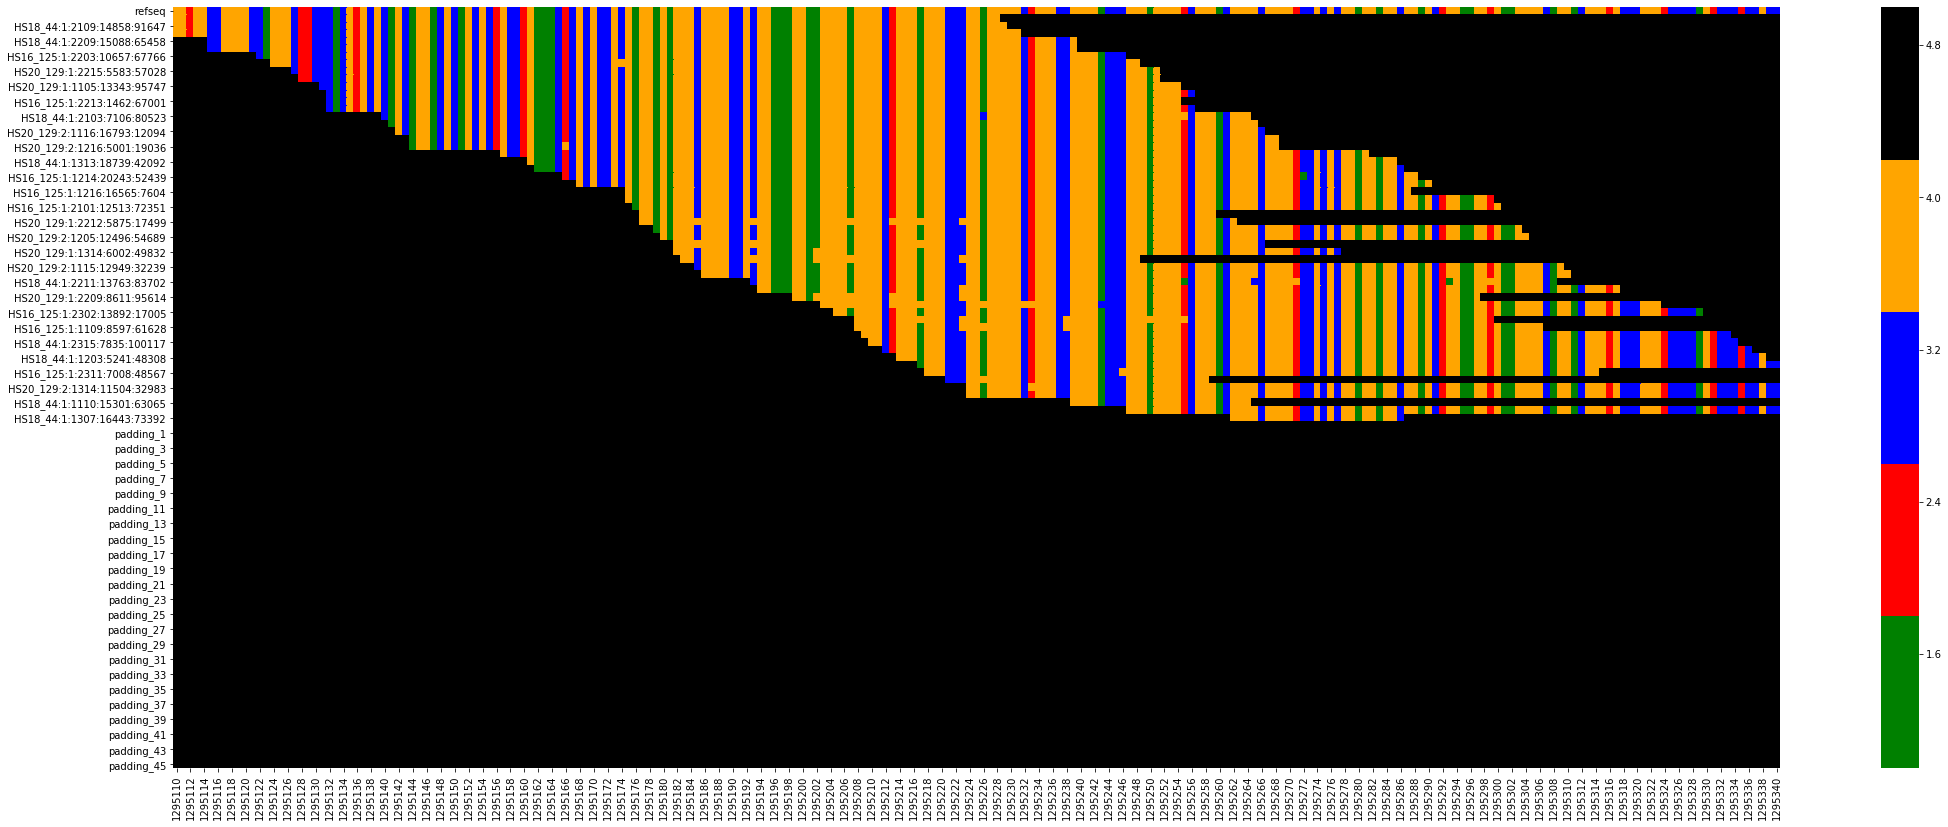

In [10]:
df = pileup_to_image(df, 5, 1295226, 115)
plot(df)

### generate training examples for GIAB project

In [30]:
a = 'CAGGTCGGCAATGTACATGAGGTCGTTGGCAATGCCGGGCAGGTCAGGCAGGTAGGATGGAACATCAATCTCAGGCACCTGGCCCAGGTCTGGCACATAGAAGTAGTTCTCTGGGACCTGCAAGATTAGGCAGGGACATGTGAGAGGT'
len(a)

148

In [11]:
of = '/projects/da_workspace/szspace/data/giab/ground_truth_calls.txt'
df = pd.read_csv(of, sep='\t')
df.head(2)

/projects/da_workspace/software/miniconda/envs/da/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,chr,pos,ref,alt,platform,dataset,genotype
0,1,239339,A,G,10X,10XChromium,0/1
1,1,239482,G,T,Illumina,HiSeqPE300x,0/1


why there are na values at some position

In [55]:
df1 = pileup_to_image(df1, 1, 239339, flank_length)
df1.head(2)
df1.shape

(24, 292)

,239334,239335,239336,239337,239338,239339,239340,239341,239342,239343
refseq,2,1,3,1,1,4,4,4,1,4
HWI-D00360:6:H81VLADXX:2:2216:21212:90399,2,1,3,1,4,4,4,4,1,5


(301, 10)

processing 1:239339


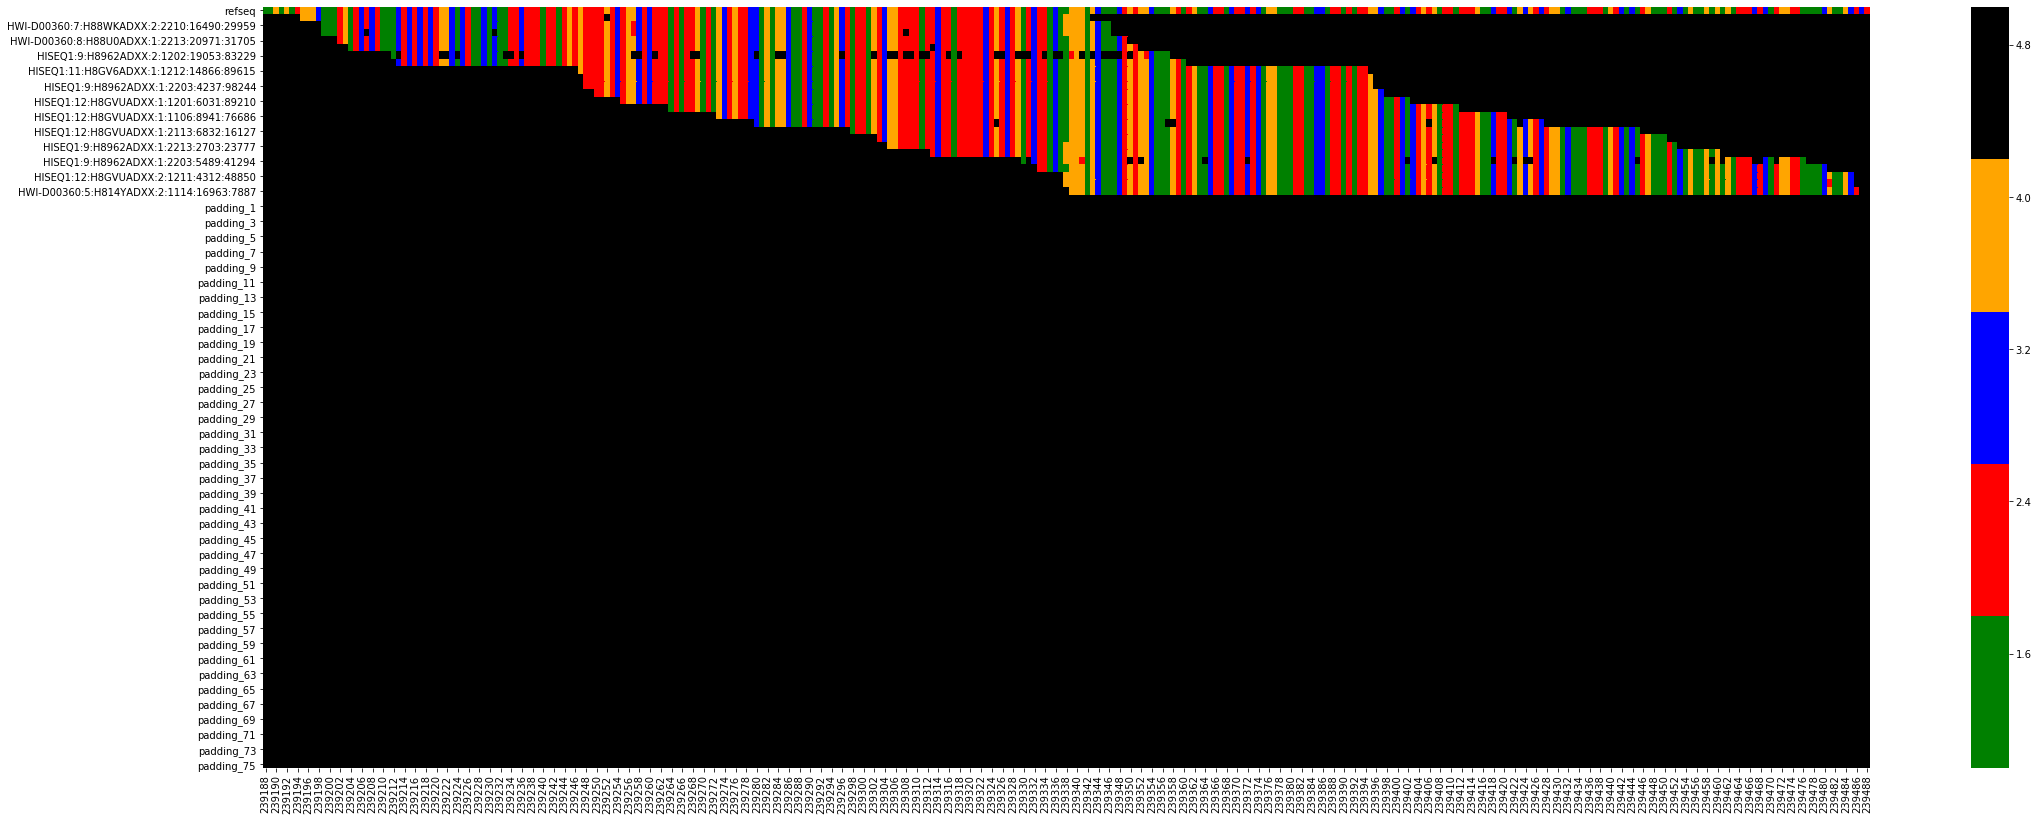

In [46]:
bam = '/projects/da_workspace/szspace/data/giab/RMNISTHS_30xdownsample.bam'
flank_length = 150
for ix, row in df.head(1).iterrows():
    chrm = row['chr']
    start = row['pos']
    print(f'processing {chrm}:{start}')
    df1 = extract_reads(bam, chrm, start)
    df1 = pileup_to_image(df1, chrm, start, flank_length)
    f, ax = plt.subplots(figsize=(0.34,0.34), dpi=10)
#     print(df1)
    plot(df1)
    plt.show()

In [43]:
# df1
df1.shape
df1.columns

(101, 231)

Int64Index([239223, 239224, 239225, 239226, 239227, 239228, 239229, 239230,
            239231, 239232,
            ...
            239444, 239445, 239446, 239447, 239448, 239449, 239450, 239451,
            239452, 239453],
           dtype='int64', length=231)

In [47]:
# df1.loc['HISEQ1:9:H8962ADXX:2:1202:19053:83229',:]

# plot pixels

https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels

In [14]:
import matplotlib.pyplot as plt
import numpy as np

data = np.random.random(size=(3, 3))
f, ax = plt.subplots(figsize=(0.34,0.34), dpi=10)
plt.imshow(data, interpolation='nearest')
plt.xticks(np.arange(0.0, 2.5, 1), np.arange(0.5, 2, 0.5))
plt.yticks(np.arange(2, -0.5, -1), np.arange(0.5, 2, 0.5))
plt.show()
plt.savefig('/home/szong/Downloads/xxxxxx.png', dpi=10)

<Figure size 432x288 with 0 Axes>

In [3]:
data

array([[0.11885332, 0.70846665, 0.14948425],
       [0.55490446, 0.92050119, 0.74996359],
       [0.1460095 , 0.58992512, 0.04528026]])